# Algorithm Description and Analysis Methodology

This document describes in detail the algorithm logic, mathematical models, and statistical testing methods used in the subsequent code to generate **(a) Satellite Longitude Analysis** and **(b) Uranus Geometric Effect Analysis**.

## 1. Satellite Relative Longitude Stacking Analysis (Panel a)

The purpose of this section is to investigate whether the heliocentric ecliptic longitude difference of satellites relative to the Earth is statistically significantly associated with the Sunspot Number (SSN).

### 1.1 Data Preprocessing and Coordinate Transformation
For each satellite $S_i$ and the Earth $E$, the heliocentric ecliptic longitudes at time $t$ are $\lambda_{S}(t)$ and $\lambda_{E}(t)$, respectively. We calculate the relative longitude difference $\Delta \lambda$ and normalize it to the interval $(-180^\circ, 180^\circ]$:

$$
\Delta \lambda(t) = \left( (\lambda_{S}(t) - \lambda_{E}(t) + 180) \pmod{360} \right) - 180
$$

### 1.2 Binning & Stacking
To detect the solar activity level under specific geometric configurations, we use a binning method:
1.  Divide the range of relative longitude $\Delta \lambda$ (e.g., $[-100^\circ, 100^\circ]$) into $N$ uniform bins.
2.  Assign data from all time points into the corresponding bins.
3.  Calculate the average SSN within each bin:
    $$\bar{S}_k = \frac{1}{n_k} \sum_{j=1}^{n_k} \text{SSN}_j, \quad \text{where } \Delta \lambda_j \in \text{Bin}_k$$
    where $\bar{S}_k$ is the average SSN of the $k$-th bin, and $n_k$ is the number of data points in that bin.

### 1.3 Statistical Significance Testing (Permutation Tests)
To verify whether the observed morphology originates from random noise, we use two non-parametric permutation test methods. The test statistic is the variance of the binned means, which measures the fluctuation intensity of the signal:
$$T = \text{Var}(\bar{S}_1, \bar{S}_2, ..., \bar{S}_N)$$

We construct $M$ permutations (e.g., $M=1000$) to calculate the null distribution:

* **Test A: Cyclic Shift**
    * **Purpose**: Preserve the temporal auto-correlation of the SSN while breaking the temporal alignment between satellite positions and solar activity.
    * **Operation**: Cyclically shift the SSN time series along the time axis by a random offset $\delta$: $\text{SSN}_{\text{new}}(t) = \text{SSN}(t + \delta)$.
    * **Significance**: This is the most rigorous test. If the observed value is significant, it indicates that the effect cannot be explained solely by the intrinsic periodicity of the solar cycle.

* **Test B: Standard Shuffle**
    * **Purpose**: Break all temporal structures.
    * **Operation**: Randomly permute the order of the SSN array.
    * **Significance**: Used to exclude pure random sampling errors.

**P-value Calculation**:
$$p = \frac{\sum_{i=1}^{M} [T_{\text{perm}}^{(i)} \geq T_{\text{obs}}]}{M}$$
If $p < 0.05$, the satellite position is considered to have a statistically significant modulation effect on the SSN distribution.

---

## 2. Uranus Geometric Torque Model (Panel b)

This section aims to test the potential physical driving effect of planetary geometric arrangements (using Uranus as an example) on solar activity extremes (Solar Min/Max). The model assumes that solar activity is influenced by tidal forces or torques generated by planets.

### 2.1 Geometric Factor Calculation
We define the following vectors and scalars:
* $\vec{r}(t)$: Unit position vector from the Sun to the planet.
* $\vec{p}$: Unit pole vector of the planet's rotation axis or orbital axis.
* $d(t)$: Distance between the Sun and the planet (AU).

We calculate two key physical factors:

1.  **Inclination Factor ($f_{inc}$)**:
    Measures the tilt of the planet's pole relative to the Sun-planet line. When the planet is at the **Equinox**, the Sun is in its equatorial plane, $\vec{r} \perp \vec{p}$, and $\vec{r} \cdot \vec{p} \approx 0$. When the planet is at the **Solstice**, the inclination is maximized.
    $$f_{inc}(t) = |\vec{r}(t) \cdot \vec{p}|$$

2.  **Distance Factor ($f_{dist}$)**:
    Measures the distance decay of the gravitational potential strength (approximated as an inverse relationship).
    $$f_{dist}(t) = \frac{1}{d(t)}$$

3.  **Combined Effect**:
    Assuming the total effect is proportional to the projected component of the inclination and modulated by distance:
    $$W(t) = f_{inc}(t) \times f_{dist}(t) = \frac{|\vec{r}(t) \cdot \vec{p}|}{d(t)}$$

### 2.2 Profile Fitting
To show the relationship between geometric factors and solar activity intensity:
1.  **X-axis**: Normalized Geometric Alignment Factor, scaled to $[-100, 100]$.
    * $0$ represents Equinox ($\perp$).
    * $\pm 100$ represents Solstice ($\parallel$).
2.  **Y-axis**: Normalized SSN intensity.
3.  **Curve Generation**: Use weighted moving average or kernel smoothing methods to calculate the average solar activity level under a specific geometric factor $W$.

### 2.3 Extreme Point Stacking
Map the historically confirmed **Solar Cycle Maxima** (red stars) and **Solar Cycle Minima** (blue squares) time points onto the geometric curve.
* **Hypothesis Testing**: If solar activity extremes tend to cluster in specific regions of the curve (e.g., near solstices or equinoxes), it suggests that planetary geometric arrangements may play a role in regulating the phase of the solar cycle ("Clock" hypothesis).


Start processing. Output directory: ../../results/03_planet_artifact
--- [Part 1] Processing Satellite Analysis (Top Panel) ---
Starting statistical tests (N=1000). This may take a moment...
--- [Part 2] Processing Solstice/Equinox Analysis (Bottom Panel) ---


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Figure saved to: ../../results/03_planet_artifact/Fig04_Uranian_Wing.eps
Data saved to: ../../results/03_planet_artifact/Fig04_Uranian_Wing_Source.xlsx
--- All tasks completed successfully ---


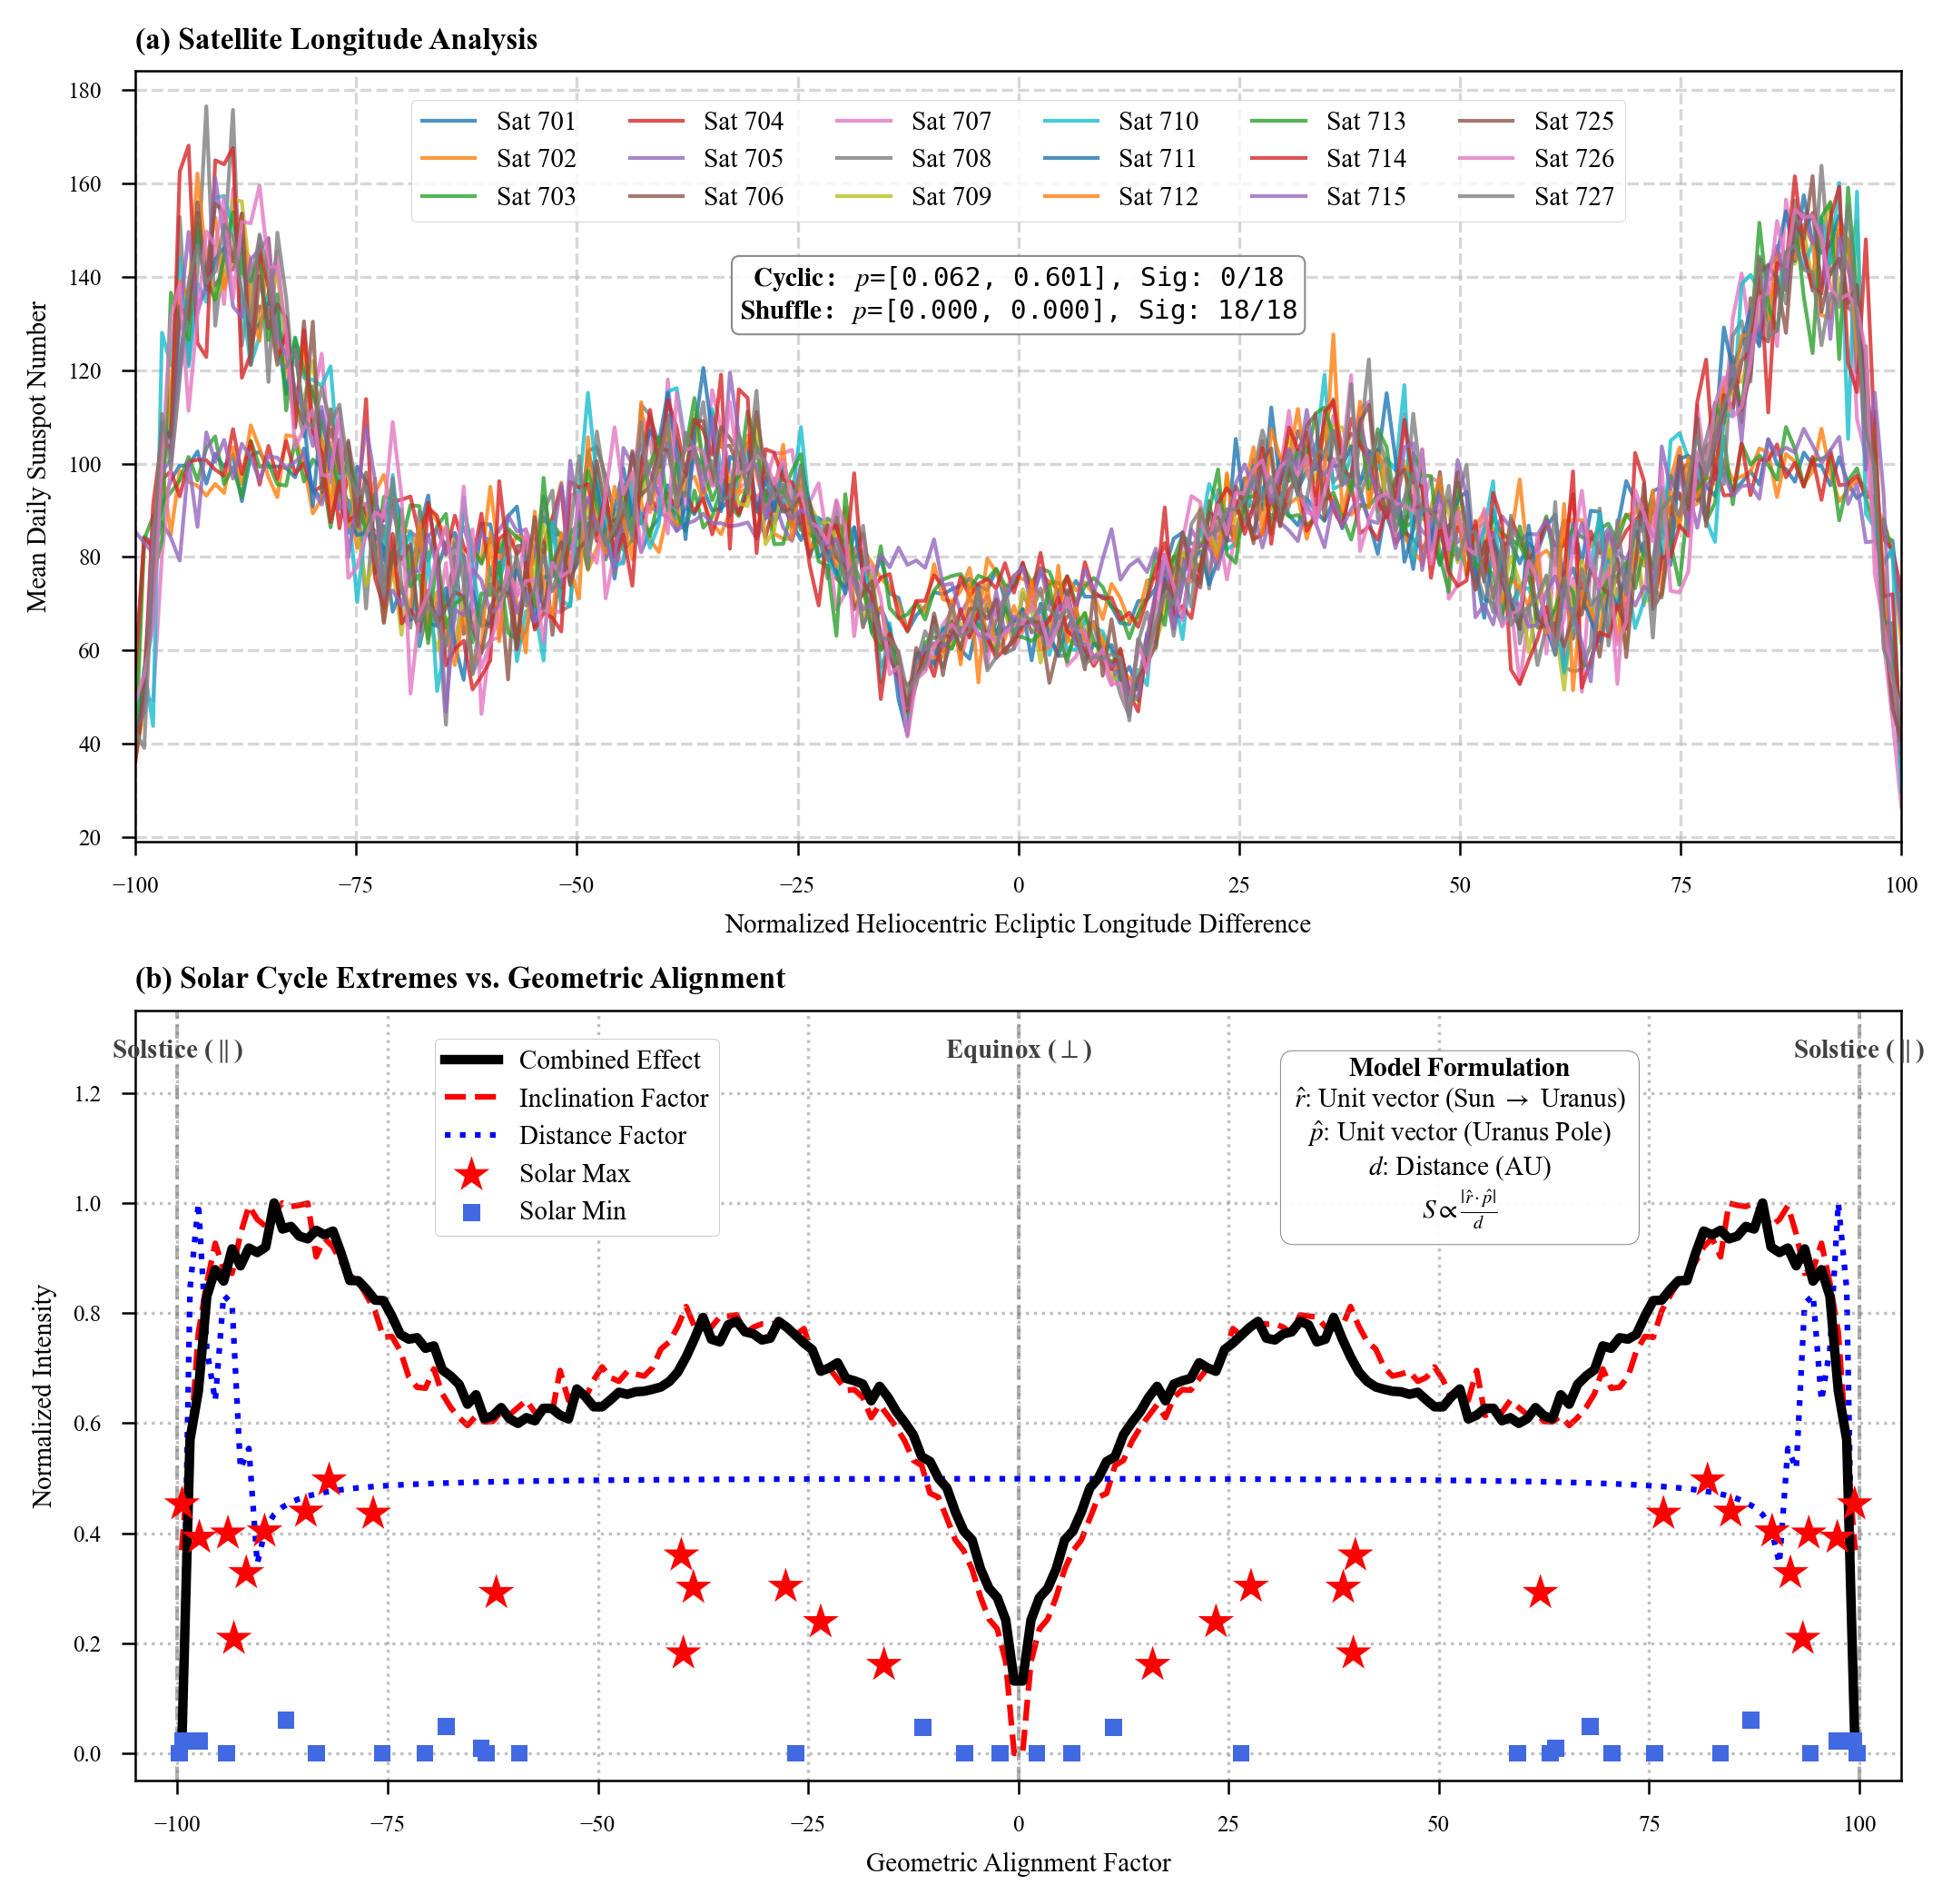

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chisquare
import os
import sys
from astropy.coordinates import Angle
import astropy.units as u

# ----------------------------------------------------------------
# 1. Global Plot Style Definition
# ----------------------------------------------------------------
def setup_astro_style():
    """
    Configures the matplotlib style for academic publication.
    """
    plt.style.use('seaborn-v0_8-paper')
    plt.rcParams.update({
        'font.size': 7,           # Global base font size reduced to 7
        'axes.labelsize': 7,      # Axis labels (X/Y Label)
        'axes.titlesize': 8,      # Subplot title
        'xtick.labelsize': 6,     # Tick numbers
        'ytick.labelsize': 6,
        'legend.fontsize': 5,     # Legend font size (critical to prevent overlap)
        'font.family': 'serif', 
        'font.serif': ['Times New Roman'],
        'mathtext.fontset': 'stix',
        'axes.linewidth': 0.6,    # Thinner lines to match small plots
        'lines.linewidth': 0.8,
        'xtick.major.width': 0.6,
        'ytick.major.width': 0.6,
        'figure.dpi': 300, 
        'savefig.bbox': 'tight',
    })

setup_astro_style()

# ----------------------------------------------------------------
# 2. Top Plot Logic: Satellite Analysis
# ----------------------------------------------------------------
def process_satellites(ax, excel_writer):
    """
    Analyzes the relationship between sunspot numbers and the relative 
    longitude of Uranus's satellites.
    """
    print("--- [Part 1] Processing Satellite Analysis (Top Panel) ---")
    
    # Path configuration
    file_path = '../../data/ready/planets_satellites_lonlat.parquet'

    if not os.path.exists(file_path):
        raise FileNotFoundError(f"[Critical] Satellite data file not found: {file_path}")

    # Read data
    try:
        df = pd.read_parquet(file_path)
    except Exception as e:
        raise IOError(f"Failed to read parquet file: {e}")

    # Satellite ID list (Uranus system)
    satellites7 = [701, 702, 703, 704, 705, 706, 707, 708, 709, 
                   710, 711, 712, 713, 714, 715, 725, 726, 727]

    # Check column names
    # Note: 799 is Uranus, 399 is Earth. We need Uranus's heliocentric longitude.
    required_columns = ['ssn', '799_lon'] + [f'{s}_lon' for s in satellites7]
    missing_cols = [col for col in required_columns if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in dataframe: {missing_cols}")

    # Data cleaning
    data = df[required_columns].dropna(subset=['ssn']).copy()

    # Calculate relative angles (using Astropy)
    # Renamed variable to 'lon_uranus' to be scientifically accurate (ID 799)
    lon_uranus = Angle(data['799_lon'].values, unit=u.deg)
    
    for sat_id in satellites7:
        lon_sat = Angle(data[f'{sat_id}_lon'].values, unit=u.deg)
        diff_angle = lon_sat - lon_uranus
        # Wrap angle at 180 degrees (-180 to 180)
        diff_normalized = diff_angle.wrap_at(180 * u.deg)
        data[f'diff_lon_{sat_id}'] = diff_normalized.value

    # Statistics and plotting preparation
    statistical_results = []
    num_bins = 200 
    num_permutations = 1000
    x_axis_display = np.linspace(-100, 100, num_bins)
    
    # Dictionary for saving Excel data
    excel_data = {'Bin_Index': range(num_bins), 'X_Axis': x_axis_display}

    print(f"Starting statistical tests (N={num_permutations}). This may take a moment...")

    for sat_id in satellites7:
        diff_col = f'diff_lon_{sat_id}'
        
        # A. Binning
        boundary = data[diff_col].abs().max()
        bins = np.linspace(-boundary, boundary, num_bins + 1)
        data['binned'] = pd.cut(data[diff_col], bins=bins, labels=False, include_lowest=True)
        
        # B. Calculate means
        binned_ssn_mean = data.groupby('binned')['ssn'].mean()
        y_values = binned_ssn_mean.reindex(range(num_bins)).values
        
        # Save to Excel dictionary
        excel_data[f'Sat_{sat_id}_Mean_SSN'] = y_values
        
        # Plotting
        ax.plot(x_axis_display, y_values, label=f'Sat {sat_id}', alpha=0.8, linewidth=1.0)
        
        # C. Statistical testing
        # 1. Chi-square
        observed_counts = data['binned'].value_counts().reindex(range(num_bins), fill_value=0)
        chi2_stat, chi2_p_value = chisquare(f_obs=observed_counts) if observed_counts.sum() > 0 else (np.nan, np.nan)

        # 2. Permutation Test
        valid_data = data.dropna(subset=['binned', 'ssn'])
        ssn_values = valid_data['ssn'].values
        binned_values = valid_data['binned'].values
        observed_statistic = binned_ssn_mean.var()
        
        perm_stats_cyclic = np.zeros(num_permutations)
        perm_stats_shuffle = np.zeros(num_permutations)

        for i in range(num_permutations):
            # Cyclic Permutation (Preserves autocorrelation)
            shift = np.random.randint(1, len(ssn_values))
            ssn_cyclic = np.roll(ssn_values, shift)
            
            # Using pandas for grouping (can be optimized with pure numpy if slow)
            temp_df_c = pd.DataFrame({'g': binned_values, 'v': ssn_cyclic})
            perm_stats_cyclic[i] = temp_df_c.groupby('g')['v'].mean().var()
            
            # Shuffle Permutation (Destroys autocorrelation)
            ssn_shuffle = np.random.permutation(ssn_values)
            temp_df_s = pd.DataFrame({'g': binned_values, 'v': ssn_shuffle})
            perm_stats_shuffle[i] = temp_df_s.groupby('g')['v'].mean().var()
        
        p_val_cyclic = np.sum(perm_stats_cyclic >= observed_statistic) / num_permutations
        p_val_shuffle = np.sum(perm_stats_shuffle >= observed_statistic) / num_permutations
        
        statistical_results.append({
            'Satellite_ID': sat_id,
            'Chi2_P': chi2_p_value,
            'Cyclic_P': p_val_cyclic,
            'Shuffle_P': p_val_shuffle
        })

    # Save data to Excel
    df_excel = pd.DataFrame(excel_data)
    df_excel.to_excel(excel_writer, sheet_name='Satellites_Curves', index=False)
    
    # Save statistical results to Excel
    df_stats = pd.DataFrame(statistical_results)
    df_stats.to_excel(excel_writer, sheet_name='Satellites_Stats', index=False)

    # Set axis labels and legend
    ax.set_xlabel('Normalized Heliocentric Ecliptic Longitude Difference')
    ax.set_ylabel('Mean Daily Sunspot Number')
    ax.set_xlim(-100, 100)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=6, fontsize=7)
    ax.set_title('(a) Satellite Longitude Analysis', loc='left', fontweight='bold')

    # Generate statistical text summary
    p_vals_cyclic = [res['Cyclic_P'] for res in statistical_results]
    p_vals_shuffle = [res['Shuffle_P'] for res in statistical_results]
    N_total = len(satellites7)
    
    stats_text = (
        f"$\\bf{{Cyclic:}}$ $p$=[{np.min(p_vals_cyclic):.3f}, {np.max(p_vals_cyclic):.3f}], Sig: {np.sum(np.array(p_vals_cyclic) < 0.05)}/{N_total}\n"
        f"$\\bf{{Shuffle:}}$ $p$=[{np.min(p_vals_shuffle):.3f}, {np.max(p_vals_shuffle):.3f}], Sig: {np.sum(np.array(p_vals_shuffle) < 0.05)}/{N_total}"
    )
    
    ax.text(0.5, 0.75, stats_text, transform=ax.transAxes,
            fontsize=7, verticalalignment='top', horizontalalignment='center',
            fontfamily='monospace', 
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.9, linewidth=0.5))
    
    ax.grid(True, linestyle='--', alpha=0.5)
    

# ----------------------------------------------------------------
# 3. Bottom Plot Logic: Geometric Analysis
# ----------------------------------------------------------------
def process_uranus_geometry(ax, excel_writer):
    """
    Analyzes the geometric alignment of Uranus's pole and the Sun
    relative to solar cycle extremes.
    """
    print("--- [Part 2] Processing Solstice/Equinox Analysis (Bottom Panel) ---")
    
    # Path configuration
    ssn_filename = '../../data/ready/ssn_daily_1849_2025.csv'
    minmax_filename = '../../data/ready/solar_cycle_minmax.csv'
    orb_filename = '../../data/ready/781_planets_dwarfs_asteroids_xyz.parquet'

    # Data loading function (Strict mode)
    def load_data():
        if not os.path.exists(ssn_filename):
            raise FileNotFoundError(f"[Critical] SSN data file missing: {ssn_filename}")
        
        df = pd.read_csv(ssn_filename)
        df['date'] = pd.to_datetime(df['date'])

        df_minmax = None
        if os.path.exists(minmax_filename):
            try:
                df_minmax = pd.read_csv(minmax_filename)
                
                def parse_date(x):
                    try:
                        if isinstance(x, str): return pd.to_datetime(x)
                        # Decimal year conversion
                        year = int(x)
                        return pd.Timestamp(year=year, month=1, day=1) + pd.Timedelta(days=(x-year)*365.25)
                    except: return pd.NaT
                
                if 'Max' in df_minmax.columns:
                    df_minmax['date_max'] = df_minmax['Max'].apply(parse_date)
                if 'start_Min' in df_minmax.columns:
                    df_minmax['date_min'] = df_minmax['start_Min'].apply(parse_date)
            except Exception as e:
                print(f"Warning: Failed to parse min/max file: {e}")
        
        return df, df_minmax

    # Orbital calculation function (Strict mode)
    def get_uranus_data(df_ssn):
        if not os.path.exists(orb_filename):
            raise FileNotFoundError(f"[Critical] Orbital data file missing: {orb_filename}")

        try:
            df_orb = pd.read_parquet(orb_filename)
            df_orb['date'] = pd.to_datetime(df_orb['date'])
            target = ['799_x', '799_y', '799_z']
            
            if not all(c in df_orb.columns for c in target):
                raise ValueError(f"Orbital file missing required columns: {target}")

            # Merge and interpolate
            temp = pd.merge(df_ssn[['date']], df_orb[['date']+target], on='date', how='left')
            coords = pd.DataFrame(temp[target].values).interpolate().bfill().values
            return coords

        except Exception as e:
            raise RuntimeError(f"Error processing orbital data: {e}")

    # Profile smoothing calculation
    def calculate_profile_norm(width_factors, ssn_values, bins=200):
        limits = width_factors / np.max(width_factors) * 100.0
        x_axis = np.linspace(-100, 100, bins+1)
        centers = (x_axis[:-1]+x_axis[1:])/2
        profile = np.zeros(bins)
        
        for i, x in enumerate(centers):
            mask = limits > np.abs(x)
            if not np.any(mask): continue
            w = 1.0/np.sqrt(limits[mask]**2 - x**2)
            profile[i] = np.sum(ssn_values[mask]*w)/np.sum(w)
        
        if profile.max() > profile.min():
            profile = (profile - profile.min())/(profile.max() - profile.min())
        return centers, profile

    # Execute calculations
    df, df_mm = load_data()
    coords = get_uranus_data(df)

    # Geometric calculations
    dist = np.linalg.norm(coords, axis=1)
    R_unit = coords / dist[:, np.newaxis]
    
    # Uranus pole coordinates (RA, Dec)
    ra, dec = np.radians(257.311), np.radians(-15.175)
    eps = np.radians(23.439) # Obliquity of the Ecliptic
    
    # Pole in Equatorial Coordinates
    pole_eq = np.array([np.cos(dec)*np.cos(ra), np.cos(dec)*np.sin(ra), np.sin(dec)])
    
    # Rotate to Ecliptic Coordinates (Rotation around X-axis)
    pole_ecl = np.array([
        pole_eq[0], 
        pole_eq[1]*np.cos(eps) + pole_eq[2]*np.sin(eps), 
        -pole_eq[1]*np.sin(eps) + pole_eq[2]*np.cos(eps)
    ])

    # Alignment factors
    f_tilt = np.abs(np.dot(R_unit, pole_ecl))
    f_dist = 1.0/dist

    # Calculate three curves for component analysis
    w_comb = f_tilt * f_dist
    x_axis, y_comb = calculate_profile_norm(w_comb, df['ssn'].values)

    w_inc = f_tilt * np.mean(f_dist)
    _, y_inc = calculate_profile_norm(w_inc, df['ssn'].values)

    w_orb = np.mean(f_tilt) * f_dist
    _, y_orb = calculate_profile_norm(w_orb, df['ssn'].values)
    
    # Save curve data to Excel
    df_curves = pd.DataFrame({
        'X_Axis': x_axis,
        'Y_Combined': y_comb,
        'Y_Inclination': y_inc,
        'Y_Distance': y_orb
    })
    df_curves.to_excel(excel_writer, sheet_name='Uranus_Curves', index=False)

    # Prepare scatter data (Max/Min points)
    max_w = np.max(w_comb)
    df['x_plot'] = (w_comb/max_w)*100.0 
    g_min, g_max = df['ssn'].min(), df['ssn'].max()
    df['ssn_norm'] = (df['ssn'] - g_min)/(g_max - g_min)

    max_pts = []
    min_pts = []
    if df_mm is not None:
        for d in df_mm['date_max'].dropna():
            idx = (df['date'] - d).abs().idxmin()
            # Only consider points within 90 days of the actual peak
            if (df.loc[idx, 'date'] - d).days < 90:
                max_pts.append((df.loc[idx, 'x_plot'], df.loc[idx, 'ssn_norm']))
        for d in df_mm['date_min'].dropna():
            idx = (df['date'] - d).abs().idxmin()
            if (df.loc[idx, 'date'] - d).days < 90:
                min_pts.append((df.loc[idx, 'x_plot'], df.loc[idx, 'ssn_norm']))

    max_pts = np.array(max_pts)
    min_pts = np.array(min_pts)
    
    # Save scatter data to Excel (flattened storage)
    scatter_data = []
    if len(max_pts) > 0:
        for p in max_pts: scatter_data.append({'Type': 'Max', 'X': p[0], 'Y': p[1]})
    if len(min_pts) > 0:
        for p in min_pts: scatter_data.append({'Type': 'Min', 'X': p[0], 'Y': p[1]})
    pd.DataFrame(scatter_data).to_excel(excel_writer, sheet_name='Uranus_Points', index=False)

    # Plotting settings
    COLOR_MIN_PT = '#4169E1'
    COLOR_MAX_PT = '#FF0000'

    ax.plot(x_axis, y_comb, 'k-', lw=2.5, label='Combined Effect', zorder=2)
    ax.plot(x_axis, y_inc, 'r--', lw=1.5, label='Inclination Factor', zorder=1)
    ax.plot(x_axis, y_orb, 'b:', lw=1.5, label='Distance Factor', zorder=1)

    if len(max_pts) > 0:
        ax.scatter(max_pts[:,0], max_pts[:,1], c=COLOR_MAX_PT, marker='*', s=100, edgecolors='none', zorder=5, label='Solar Max')
        ax.scatter(-max_pts[:,0], max_pts[:,1], c=COLOR_MAX_PT, marker='*', s=100, edgecolors='none', zorder=5)

    if len(min_pts) > 0:
        ax.scatter(min_pts[:,0], min_pts[:,1], c=COLOR_MIN_PT, marker='s', s=20, edgecolors='none', zorder=5, label='Solar Min')
        ax.scatter(-min_pts[:,0], min_pts[:,1], c=COLOR_MIN_PT, marker='s', s=20, edgecolors='none', zorder=5)

    ax.set_title("(b) Solar Cycle Extremes vs. Geometric Alignment", loc='left', fontweight='bold')
    ax.set_xlabel("Geometric Alignment Factor")
    ax.set_ylabel("Normalized Intensity")
    ax.set_xlim(-105, 105)
    ax.set_ylim(-0.05, 1.35) # Slightly increase space for formula

    # Reference lines
    line_props = dict(color='gray', linestyle='--', alpha=0.6, linewidth=1, zorder=0)
    text_props = dict(ha='center', va='bottom', fontsize=7, fontweight='bold', color='#404040')

    ax.axvline(0, **line_props)
    ax.text(0, 1.25, r"Equinox ($\perp$)", **text_props)
    ax.axvline(100, **line_props)
    ax.text(100, 1.25, r"Solstice ($\parallel$)", **text_props)
    ax.axvline(-100, **line_props)
    ax.text(-100, 1.25, r"Solstice ($\parallel$)", **text_props)

    # Legend
    ax.legend(loc='upper center', bbox_to_anchor=(0.25, 0.98), 
              fontsize=7, framealpha=1.0, fancybox=True, ncol=1) 
    
    # Formula text
    formula_text = (
        r"$\bf{Model\ Formulation}$" + "\n" +
        r"$\hat{r}$: Unit vector (Sun $\to$ Uranus)" + "\n" +
        r"$\hat{p}$: Unit vector (Uranus Pole)" + "\n" +
        r"$d$: Distance (AU)" + "\n" +
        r"$S \propto \frac{|\hat{r} \cdot \hat{p}|}{d}$"
    )
    ax.text(0.75, 0.94, formula_text, fontsize=7, 
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.95),
            horizontalalignment='center', verticalalignment='top', 
            transform=ax.transAxes, zorder=6)
    
    ax.grid(True, linestyle=':', color='gray', alpha=0.5)

# ----------------------------------------------------------------
# 4. Main Execution Block
# ----------------------------------------------------------------
if __name__ == "__main__":
    # Prepare output path
    output_dir = '../../results/03_planet_artifact'
    os.makedirs(output_dir, exist_ok=True)
    excel_path = os.path.join(output_dir, 'Fig04_Uranian_Wing_Source.xlsx')
    fig_path = os.path.join(output_dir, 'Fig04_Uranian_Wing.eps')

    print(f"Start processing. Output directory: {output_dir}")

    # Initialize Excel Writer
    with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
        
        # Create canvas: width 7.2 inches, height 7 inches
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.2, 7))
        
        # Execute top panel analysis (Satellite)
        process_satellites(ax1, writer)
        
        # Execute bottom panel analysis (Uranus Geometry)
        process_uranus_geometry(ax2, writer)
        
        # Adjust layout
        plt.tight_layout()
        
        # Save figure
        plt.savefig(fig_path, format='eps')
        print(f"Figure saved to: {fig_path}")

    print(f"Data saved to: {excel_path}")
    print("--- All tasks completed successfully ---")
    
    plt.show()